In [81]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.cytoselfmodule import CytoselfLightningModule
import numpy as np
from omegaconf import OmegaConf


# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-05-26/20-52-13"
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-07-12/03-35-27"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    clm = CytoselfLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        num_class=pdm.num_class,
    )

/tmp/ipykernel_19293/3284299096.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-07-12/03-35-27/checkpoints/last.ckpt


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [ ]:
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)
batch = next(iter(dl))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch['image'][2, 0])

In [ ]:
batch['image'].shape

In [ ]:
input_images = batch['image']
output_images, output_logits = clm.model(input_images)
output_images = output_images.detach().numpy()

In [ ]:
plt.imshow(output_images[2, 0])

In [ ]:
data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [ ]:
embedding = clm.model(batch['image'], 'vqvec2')

In [ ]:
clm.model(batch['image'], 'vqvec2')

In [ ]:
import torch
from tqdm import tqdm


clm.model.to('cuda')
clm.model.eval()
embeddings = []
with torch.no_grad():
    for batch in tqdm(pdm.val_dataloader()):
        emb = clm.model(batch['image'].to('cuda'), 'vqvec2')
        embeddings.append(emb.detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)

In [ ]:
import zarr
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "embeddings_5.zarr")

shape = embeddings.shape
chunks = (100, None, None, None)
z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
z[:] = embeddings

# embeddings = np.asarray(zarr.open(zarr_path, mode='r'))

In [ ]:
embeddings.shape

In [ ]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

In [ ]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [ ]:
reduced_embedding.shape

In [ ]:
plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], marker='.', s=.1);

In [ ]:
labels = pdm.val_dataloader().dataset.labels['localization']

In [ ]:
labels[labels == ''] = 'other'

In [ ]:
import seaborn as sns

In [ ]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=labels, s=2, alpha=0.9)

## Remake data

In [ ]:
import numpy as np

a = np.load('/home/ec2-user/proteoscope/notebooks/sample_data/ATL3_label.npy', allow_pickle=True)
b = np.load('/home/ec2-user/proteoscope/notebooks/sample_data/ATL3_nuc.npy')

In [ ]:
b.shape

In [113]:
import os


datapath = '/home/ec2-user/cytoself-data'
images_path = os.path.join(datapath, 'images.zarr')
labels_path = os.path.join(datapath, 'labels.csv')

In [114]:
datapath = '/home/ec2-user/cytoself-data'

In [ ]:
os.makedirs('/home/ec2-user/cytoself-data/orig')

In [115]:
import dask.array as da
import pandas as pd


images = da.from_zarr(images_path)
labels = pd.read_csv(labels_path, index_col=0)
labels['localization'] = labels['localization'].fillna('other')

In [116]:
names = labels['name'].unique()

In [4]:
names[]

SyntaxError: invalid syntax (735523878.py, line 1)

In [82]:
from tqdm import tqdm

In [1]:
for name in tqdm(names[:200]):
    df = labels[labels['name'] == name]
    label_array = df[['ensg', 'name', 'localization']].to_numpy()
    indices = df['index'].values
    # image_block = np.asarray(images[indices])
    # np.save(datapath + '/orig/' + name + '_label.npy', label_array)
    # np.save(datapath + '/orig/' + name + '_pro.npy', image_block[:, :, :, 0])
    # np.save(datapath + '/orig/' + name + '_nuc.npy', image_block[:, :, :, 1])
    print(np.max(indices))

NameError: name 'tqdm' is not defined

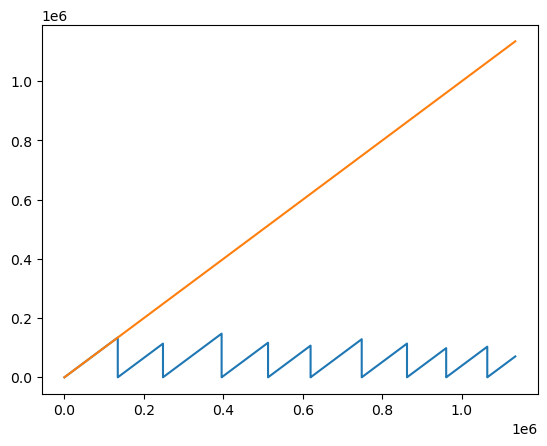

In [74]:
plt.plot(labels['index'])
plt.plot(labels.index)

In [122]:
names_red = sorted(names[:200])[:2]

In [123]:
names_red

['ACLY', 'ACTB']

In [ ]:
df = labels[labels['name'] == name]

In [ ]:
indices = df['index'].values

In [ ]:
images[indices]

In [ ]:
b = np.load('/home/ec2-user/cytoself-data/orig/CDC37_pro.npy')

In [ ]:
b.shape

## Custom

In [1]:
from proteoscope.datamodule import ProteoscopeDataModule
import matplotlib.pyplot as plt

In [2]:
import os

datapath = '/home/ec2-user/cytoself-data'
images_path = os.path.join(datapath, 'images.zarr')
labels_path = os.path.join(datapath, 'labels.csv')

pdm = ProteoscopeDataModule(images_path, labels_path, 32, 0)
pdm.setup()

In [ ]:
pdm.train_dataset.labels = pdm.train_dataset.labels[::100]

In [ ]:
pdm.train_dataset.labels = pdm.train_dataset.labels[pdm.train_dataset.labels['localization'] != '']

In [8]:
pdm.train_dataset.labels = pdm.labels[pdm.labels['name'].isin(names[:2])]
# pdm.train_dataset.labels = pdm.labels[pdm.labels['name'].isin(['ACTB', 'ACLY'])]

In [9]:
pdm.train_dataset.labels

,index,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation,localization,full_index
0,0,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,,0
1,1,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,,1
2,2,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,,2
3,3,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,val,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,,3
4,4,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,2942,ENSG00000100591,AHSA1,nucleoplasm;cytoplasmic,,,3,6059,train,train,1,MAKWGEGDPRWIVEERADATNVNNWHWTERDASNWSTDKLKTLFLA...,ENSP00000216479,1,338,,2942
2943,2943,ENSG00000100591,AHSA1,nucleoplasm;cytoplasmic,,,3,6059,train,train,1,MAKWGEGDPRWIVEERADATNVNNWHWTERDASNWSTDKLKTLFLA...,ENSP00000216479,1,338,,2943
2944,2944,ENSG00000100591,AHSA1,nucleoplasm;cytoplasmic,,,3,6059,train,test,1,MAKWGEGDPRWIVEERADATNVNNWHWTERDASNWSTDKLKTLFLA...,ENSP00000216479,1,338,,2944
2945,2945,ENSG00000100591,AHSA1,nucleoplasm;cytoplasmic,,,3,6059,train,train,1,MAKWGEGDPRWIVEERADATNVNNWHWTERDASNWSTDKLKTLFLA...,ENSP00000216479,1,338,,2945


In [135]:
len(pdm.labels)

1134592

In [ ]:
pdm.val_images_dataset.labels = pdm.val_images_dataset.labels[pdm.val_images_dataset.labels['localization'] != '']

In [ ]:
pdm.val_images_dataset.labels = pdm.val_images_dataset.labels[:100]

In [3]:
pdm.train_loader = pdm.train_dataloader()
pdm.train_variance = 0.0167
pdm.train_labels = pdm.num_class #len(pdm.train_dataset.labels['label'].unique())
pdm.val_loader = pdm.val_dataloader()
pdm.val_variance = 0.0167
pdm.val_labels = pdm.num_class #len(pdm.train_dataset.labels['label'].unique())
pdm.test_loader = pdm.val_dataloader()
pdm.test_variance = 0.0167
pdm.test_labels = pdm.num_class #len(pdm.train_dataset.labels['label'].unique())

## Train

In [120]:
from os.path import join
import numpy as np
import torch
import matplotlib.pyplot as plt

from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.trainer.utils.plot_history import plot_history_cytoself

data_ch = ['pro', 'nuc'] # , 'nucdist', 'label']
datapath = '/home/ec2-user/cytoself-data/orig'
# datapath = 'sample_data'
pdm2 = DataManagerOpenCell(datapath, data_ch, data_split=(0, 0, 1.0), fov_col=None)
pdm2.const_dataloader(batch_size=1, label_name_position=0, labels_toload=list(names[:100]))

Loading pro data...




























100%|██████████| 100/100 [00:51<00:00,  1.94it/s]


Loading nuc data...



























100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Loading label data...



100%|██████████| 100/100 [00:00<00:00, 3070.57it/s]


Splitting data...
Computing variance of test data...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:15                                                                                   │
│                                                                                                  │
│   12 datapath = '/home/ec2-user/cytoself-data/orig'                                              │
│   13 # datapath = 'sample_data'                                                                  │
│   14 pdm2 = DataManagerOpenCell(datapath, data_ch, data_split=(0, 0, 1.0), fov_col=None)         │
│ ❱ 15 pdm2.const_dataloader(batch_size=1, label_name_position=0, labels_toload=list(names[:100    │
│   16                                                                                             │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/cytoself/datamanager/opencell.py:334 in      │
│ const_dataloader                                                                                 │
│                                                                                                  │
│   331 │   │   │   │   test_dataset, batch_size, shuffle=shuffle_test, num_workers=self.num_wor   │
│   332 │   │   │   )                                                                              │
│   333 │   │   │   print('Computing variance of test data...')                                    │
│ ❱ 334 │   │   │   self.test_variance = np.var(test_data).item()                                  │
│   335 │                                                                                          │
│   336 │   @staticmethod                                                                          │
│   337 │   def download_sample_data(output: Optional[str] = 'sample_data'):                       │
│ in var:180                                                                                       │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715 in var        │
│                                                                                                  │
│   3712 │   │   else:                                                                             │
│   3713 │   │   │   return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)              │
│   3714 │                                                                                         │
│ ❱ 3715 │   return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,                   │
│   3716 │   │   │   │   │   │    **kwargs)                                                        │
│   3717                                                                                           │
│   3718                                                                                           │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:233 in _var           │
│                                                                                                  │
│   230 │   # Compute sum of squared deviations from mean                                          │
│   231 │   # Note that x may not be inexact and that we need it to be an array,                   │
│   232 │   # not a scalar.                                                                        │
│ ❱ 233 │   x = asanyarray(arr - arrmean)                                                          │
│   234 │                                                                                          │
│   235 │   if issubclass(arr.dtype.type, (nt.floating, nt.integer)):                              │
│   236 │   │   x = um.multiply(x, x, out=x)                 

In [11]:
pdm2.test_loader.dataset.label[:20]

array([['ENSG00000100591', 'AHSA1', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000100591', 'AHSA1', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000100591', 'AHSA1', 'other'],
       ['ENSG00000100591', 'AHSA1', 'other'],
       ['ENSG00000100591', 'AHSA1', 'other'],
       ['ENSG00000075624', 'ACTB', 'other']], dtype=object)

In [9]:
pdm2

In [4]:
# from cytoself.datamanager.opencell import get_file_df


# file_df = get_file_df(datapath)


In [5]:
# file_df.iloc[:, 0].str.split('/', expand=True).iloc[:, -1].str.split('_', expand=True).iloc[:, 0]

In [6]:
# pdm2.determine_load_paths(label_name_position=1, labels_toload=list(names[:5]))

In [7]:
# datamanager.train_variance
# datamanager.train_loader.dataset[2]['image'].shape
# plt.imshow(datamanager.train_loader.dataset[2]['image'][0])

In [5]:
# num_classes = len(pdm.unique_labels)
# num_classes = pdm.train_labels
num_classes = 1049
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 2048, 'embedding_dim': 64, 'channel_split': 1},
    'fc_args': {'num_layers': 2},
    'num_class': num_classes,
    'fc_input_type': 'vqvec',
}
train_args = {
    'lr': 1e-3,
    'max_epoch': 30,
    'reducelr_patience': 3,
    'reducelr_increment': 0.1,
    'earlystop_patience': 60,
}
trainer = CytoselfFullTrainer(train_args, homepath='demo_output4', model_args=model_args)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [6]:
trainer.load_checkpoint('/home/ec2-user/proteoscope/notebooks/demo_output3/checkpoints', 9)

/home/ec2-user/proteoscope/notebooks/demo_output3/checkpoints/checkpoint_ep9.chkp has been loaded.


In [ ]:
trainer.fit(pdm, tensorboard_path='tb_logs')

In [ ]:
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict['visualization'])

In [ ]:
trainer.history

tensor([1])


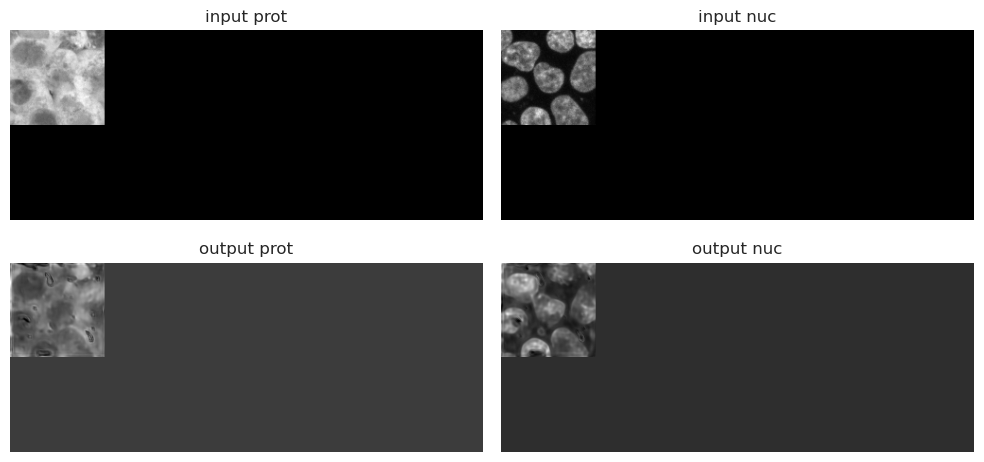

In [46]:
batch = next(iter(pdm2.test_loader))
img = batch['image'].detach().cpu().numpy()
print(batch['label'])
data_ch = ['prot', 'nuc']
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [20]:
# np.unique(np.array(pdm.test_loader.dataset.labels['localization']))

In [7]:
pdm.test_loader.dataset.label = np.array(pdm.test_loader.dataset.labels['localization'])[..., None]

In [17]:
pdm.train_loader.dataset.label = np.array(pdm.train_loader.dataset.labels['name'])[..., None]

In [105]:
len(pdm.test_loader.dataset)

2205

In [45]:
batch = next(iter(pdm2.test_loader))

In [46]:
batch['image'].shape

torch.Size([32, 2, 100, 100])

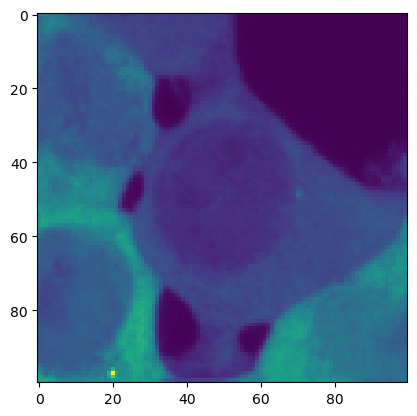

In [47]:
plt.imshow(batch['image'][11, 0])

In [20]:
pdm2.test_loader.dataset.label

array([['ENSG00000100591', 'AHSA1', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ...,
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other'],
       ['ENSG00000075624', 'ACTB', 'other']], dtype=object)

In [57]:
pdm2.test_loader.dataset.data.shape

(5428, 2, 100, 100)

In [58]:
pdm2.test_loader.dataset.data.mean()

0.17644088342446634

In [61]:
aa = '/home/ec2-user/cytoself-data/orig/ACLY_pro.npy'
aa = np.load(aa)

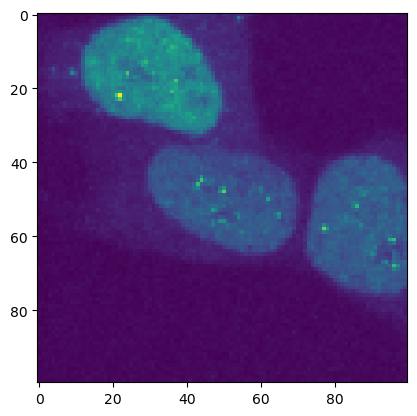

In [71]:
plt.imshow(aa[0, :, :])

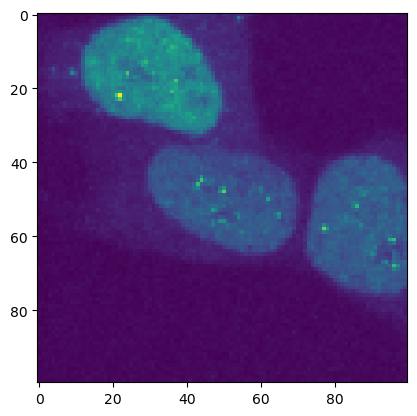

In [70]:
plt.imshow(z[3015, :, :, 0])

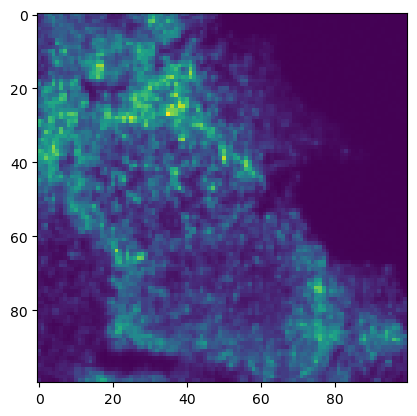

In [76]:
plt.imshow(z[-1, :, :, 0])

In [29]:
pdm.label

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 pdm.labels                                                                                   │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'DataManagerOpenCell' object has no attribute 'labels'

In [43]:
batch2 = next(iter(pdm.train_dataloader()))

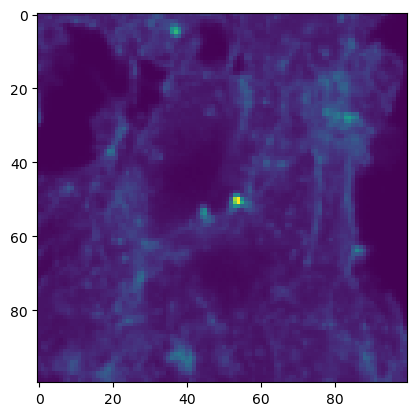

In [44]:
plt.imshow(batch2['image'][0, 0])

In [26]:
X = np.asarray(pdm.val_images_dataset.images[0])

In [28]:
pdm.val_images_dataset.images[0].compute()

array([[[ 1.67288363e-03,  9.40869655e-03, -5.10000000e+01,
          0.00000000e+00],
        [ 1.56727235e-03,  1.06420470e-02, -5.20000000e+01,
          0.00000000e+00],
        [ 1.71090371e-03,  8.43963679e-03, -5.30000000e+01,
          0.00000000e+00],
        ...,
        [ 2.78391503e-03,  9.09154955e-03, -2.80000000e+01,
          0.00000000e+00],
        [ 2.90219975e-03,  1.06949043e-02, -2.80178509e+01,
          0.00000000e+00],
        [ 2.50087655e-03,  7.25914445e-03, -2.80713367e+01,
          0.00000000e+00]],

       [[ 2.19249143e-03,  7.68200727e-03, -5.10098038e+01,
          0.00000000e+00],
        [ 1.90522859e-03,  8.65106750e-03, -5.20096130e+01,
          0.00000000e+00],
        [ 1.77849503e-03,  9.47917439e-03, -5.30094337e+01,
          0.00000000e+00],
        ...,
        [ 3.74709046e-03,  8.84487946e-03, -2.70000000e+01,
          0.00000000e+00],
        [ 3.15144239e-03,  8.58059060e-03, -2.70185127e+01,
          0.00000000e+00],
        [ 3.244

In [26]:
import zarr
z = zarr.open(images_path, 'r')

In [53]:
indices = list(pdm.labels['index'])
z.get_orthogonal_selection((indices, slice(None), slice(None), slice(None)))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 indices = list(pdm.labels['index'])                                                          │
│ ❱ 2 z.get_orthogonal_selection((indices, slice(None), slice(None), slice(None))).shape           │
│   3                                                                                              │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/zarr/core.py:1101 in                         │
│ get_orthogonal_selection                                                                         │
│                                                                                                  │
│   1098 │   │   # setup indexer                                                                   │
│   1099 │   │   indexer = OrthogonalIndexer(selection, self)                                      │
│   1100 │   │                                                                                     │
│ ❱ 1101 │   │   return self._get_selection(indexer=indexer, out=out, fields=fields)               │
│   1102 │                                                                                         │
│   1103 │   def get_coordinate_selection(self, selection, out=None, fields=None):                 │
│   1104 │   │   """Retrieve a selection of individual items, by providing the indices             │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/zarr/core.py:1269 in _get_selection          │
│                                                                                                  │
│   1266 │   │                                                                                     │
│   1267 │   │   # setup output array                                                              │
│   1268 │   │   if out is None:                                                                   │
│ ❱ 1269 │   │   │   out = np.empty_like(self._meta_array, shape=out_shape,                        │
│   1270 │   │   │   │   │   │   │   │   dtype=out_dtype, order=self._order)                       │
│   1271 │   │   else:                                                                             │
│   1272 │   │   │   check_array_shape('out', out, out_shape)                                      │
│ in empty_like:180                                                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
MemoryError: Unable to allocate 338. GiB for an array with shape (1134592, 100, 100, 4) and data type float64

In [52]:
list(pdm.labels['index'])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [18]:
pdm.val_images_dataset.labels

,index,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation,localization
3,3,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,val,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
21,21,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,val,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
34,34,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,val,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
44,44,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,val,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
45,45,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,val,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134556,70481,ENSG00000125912,NCLN,er,,vesicles,2039,38862,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563,
1134564,70489,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563,
1134567,70492,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563,
1134583,70508,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563,


In [81]:
batch['image'].shape

torch.Size([32, 2, 100, 100])

In [83]:
(batch['image'] - batch2['image'][:32]).max()

tensor(0.9981, dtype=torch.float64)

In [95]:
row = pdm.labels.iloc[0]

In [96]:
row[]

index                                                                  0
ensg                                                     ENSG00000075624
name                                                                ACTB
loc_grade1                                         membrane;cytoskeleton
loc_grade2                                                   cytoplasmic
loc_grade3                                                              
protein_id                                                             2
FOV_id                                                             27979
split_protein                                                      train
split_images                                                       train
label                                                                  0
Peptide                MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...
Protein stable ID                                        ENSP00000494750
seq_embedding_index                                

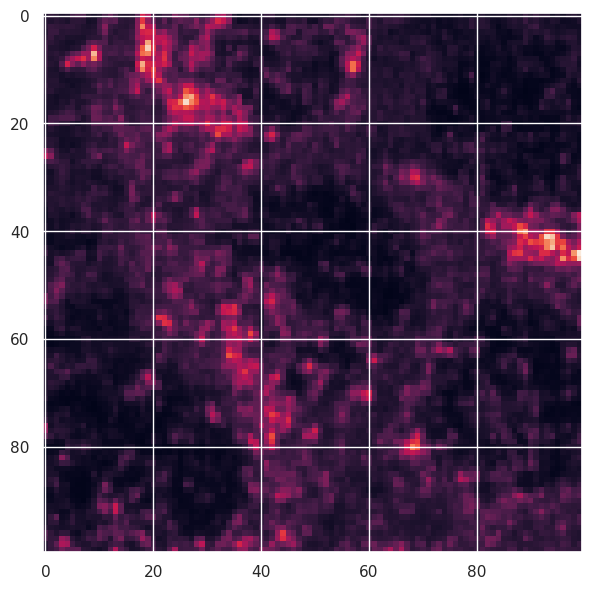

In [94]:
plt.imshow(batch['image'][5, 0])

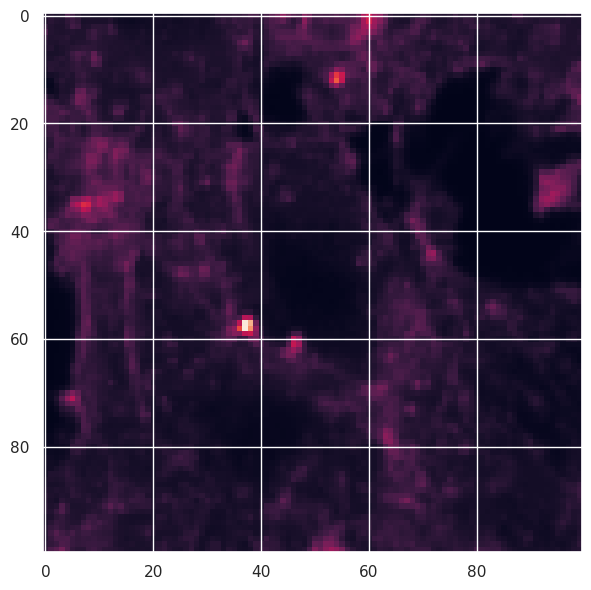

In [93]:
plt.imshow(batch2['image'][5, 0])

In [42]:
len(pdm2.test_loader.dataset)

5428

In [41]:
len(pdm.train_dataset)

5428

In [74]:
pdm.train_dataset.labels

,index,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation,localization
0,0,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
1,1,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
2,2,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
4,4,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
5,5,ENSG00000075624,ACTB,membrane;cytoskeleton,cytoplasmic,,2,27979,train,train,0,MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVG...,ENSP00000494750,0,375,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10511,10511,ENSG00000162616,DNAJB4,cytoplasmic;nucleoplasm,,,18,27668,train,train,8,MGKDYYCILGIEKGASDEDIKKAYRKQALKFHPDKNKSPQAEEKFK...,ENSP00000359799,9,337,
10512,10512,ENSG00000162616,DNAJB4,cytoplasmic;nucleoplasm,,,18,27668,train,train,8,MGKDYYCILGIEKGASDEDIKKAYRKQALKFHPDKNKSPQAEEKFK...,ENSP00000359799,9,337,
10513,10513,ENSG00000162616,DNAJB4,cytoplasmic;nucleoplasm,,,18,27668,train,train,8,MGKDYYCILGIEKGASDEDIKKAYRKQALKFHPDKNKSPQAEEKFK...,ENSP00000359799,9,337,
10514,10514,ENSG00000162616,DNAJB4,cytoplasmic;nucleoplasm,,,18,27668,train,train,8,MGKDYYCILGIEKGASDEDIKKAYRKQALKFHPDKNKSPQAEEKFK...,ENSP00000359799,9,337,


In [147]:
len(pdm.train_dataset)

2205

Computing embeddings from image...


Infer: 100%|██████████| 93/93 [00:05<00:00, 16.59it/s]


embeddings vqvec2 have been saved at demo_output4/embeddings
Computing UMAP coordinates from embeddings...
UMAP( verbose=True)
Mon Jul 17 19:19:49 2023 Construct fuzzy simplicial set
Mon Jul 17 19:19:55 2023 Finding Nearest Neighbors
Mon Jul 17 19:19:59 2023 Finished Nearest Neighbor Search
Mon Jul 17 19:20:02 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jul 17 19:20:07 2023 Finished embedding


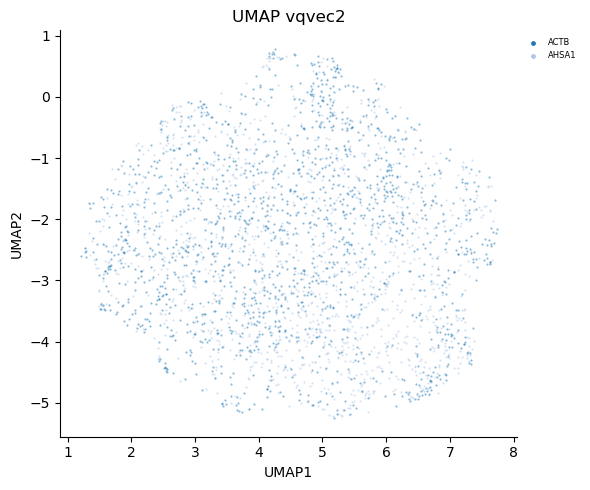

In [18]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm.train_loader,
    group_col=0,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [111]:
trainer.model.eval()

CytoselfFull(
  (encoders): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              

In [121]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm2.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

Computing embeddings from image...



 35%|███▌      | 35/100 [02:46<05:08,  4.75s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 from cytoself.analysis.analysis_opencell import AnalysisOpenCell                            │
│    2                                                                                             │
│    3 analysis = AnalysisOpenCell(pdm, trainer)                                                   │
│ ❱  4 umap_data = analysis.plot_umap_of_embedding_vector(                                         │
│    5 │   data_loader=pdm2.test_loader,                                                           │
│    6 │   group_col=2,                                                                            │
│    7 │   output_layer=f'{model_args["fc_input_type"]}2',                                         │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/cytoself/analysis/analysis_opencell.py:73 in │
│ plot_umap_of_embedding_vector                                                                    │
│                                                                                                  │
│    70 │   │                                                                                      │
│    71 │   │   # Get compute umap data from embedding_data                                        │
│    72 │   │   if umap_data is None:                                                              │
│ ❱  73 │   │   │   umap_data = self.compute_umap(data_loader, embedding_data, image_data, savep   │
│    74 │   │                                                                                      │
│    75 │   │   # Construct group annotation                                                       │
│    76 │   │   label_converted, unique_groups = self.group_labels(label_data, group_col, unique   │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/cytoself/analysis/analysis_opencell.py:113   │
│ in compute_umap                                                                                  │
│                                                                                                  │
│   110 │   │   """                                                                                │
│   111 │   │   if embedding_data is None:                                                         │
│   112 │   │   │   print('Computing embeddings from image...')                                    │
│ ❱ 113 │   │   │   embedding_data = self.trainer.infer_embeddings(                                │
│   114 │   │   │   │   image_data if data_loader is None else data_loader,                        │
│   115 │   │   │   │   **{a: kwargs[a] for a in inspect.signature(self.trainer.infer_embeddings   │
│   116 │   │   │   )                                                                              │
│                                                                                                  │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/autograd/grad_mode.py:27 in            │
│ decorate_context                                                                                 │
│                                                                                                  │
│    24 │   │   @functools.wraps(func)                                                             │
│    25 │   │   def decorate_context(*args, **kwargs):                                             │
│    26 │   │   │   with self.clone():                                                             │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)         

In [ ]:
np.unique(pdm.test_loader.dataset.label)

Computing embeddings from image...


Infer: 100%|██████████| 2947/2947 [01:03<00:00, 46.63it/s]


embeddings vqvec2 have been saved at demo_output4/embeddings
Computing UMAP coordinates from embeddings...
UMAP( verbose=True)
Mon Jul 17 19:40:19 2023 Construct fuzzy simplicial set
Mon Jul 17 19:40:25 2023 Finding Nearest Neighbors
Mon Jul 17 19:40:25 2023 Finished Nearest Neighbor Search
Mon Jul 17 19:40:25 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon Jul 17 19:40:30 2023 Finished embedding


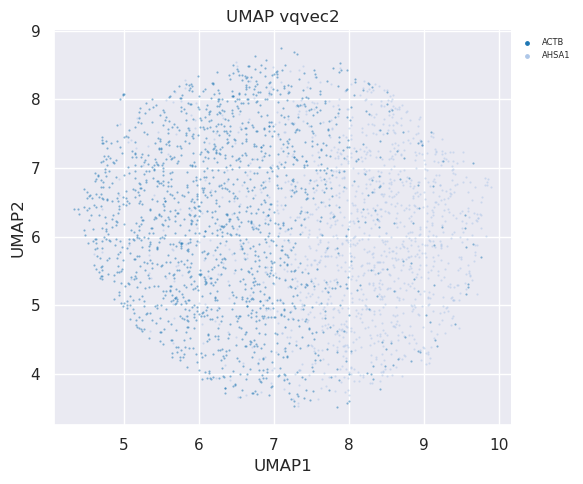

In [47]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm2.test_loader,
    group_col=1,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm.train_loader,
    group_col=0,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm.test_loader,
    group_col=0,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm.train_loader,
    group_col=0,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm.train_loader,
    group_col=0,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
len(np.unique(pdm.train_loader.dataset.label[:, 0]))

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(pdm, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=pdm.test_loader,
    group_col=0,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
pdm.train_dataset.labels

In [ ]:
emb2 = np.load('/home/ec2-user/proteoscope/notebooks/demo_output3/embeddings/vqvec2.npy')

In [ ]:
emb2.shape

In [ ]:
emb2[:2, :2, :2, :2]

In [ ]:
batch = next(iter(pdm.test_loader))
emb = trainer.model(batch['image'].to('cuda'), 'vqvec1')

In [ ]:
batch['image'].shape

In [ ]:
emb.shape

In [ ]:
pdm.train_dataset.labels = pdm.train_dataset.labels[::100]

In [20]:
from tqdm import tqdm
raw_images2 = []
for batch in tqdm(pdm2.test_loader):
    raw_images2.append(batch['image'])
raw_images2 = np.concatenate(raw_images2, axis=0)

100%|██████████| 93/93 [00:00<00:00, 207.28it/s]


In [16]:
raw_images2.shape

(2947, 2, 100, 100)

In [21]:
from tqdm import tqdm
raw_images = []
for batch in tqdm(pdm.train_loader):
    raw_images.append(batch['image'])
raw_images = np.concatenate(raw_images, axis=0)

100%|██████████| 93/93 [00:01<00:00, 46.96it/s]


In [22]:
import torch
from tqdm import tqdm


# trainer.model.to('cuda')
embeddings = []
# localizations = []
for batch in tqdm(raw_images):
    emb = trainer.model(torch.from_numpy(batch).unsqueeze_(0).to('cuda').float(), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
    # localizations.append(batch['label'])
embeddings = np.concatenate(embeddings, axis=0)
# localizations = np.concatenate(localizations, axis=0)

100%|██████████| 2947/2947 [01:12<00:00, 40.73it/s]


In [38]:
import torch
from tqdm import tqdm


# trainer.model.to('cuda')
embeddings2 = []
# localizations = []
for batch in tqdm(raw_images2):
    emb = trainer.model(torch.from_numpy(batch).unsqueeze_(0).to('cuda').float(), 'vqvec2')
    embeddings2.append(emb.detach().cpu().numpy())
    # localizations.append(batch['label'])
embeddings2 = np.concatenate(embeddings2, axis=0)
# localizations = np.concatenate(localizations, axis=0)

100%|██████████| 2947/2947 [01:12<00:00, 40.67it/s]


In [43]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))


In [41]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer2 = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer2.fit(embeddings2.reshape(embeddings2.shape[0], -1))
reduced_embedding2 = reducer2.transform(embeddings2.reshape(embeddings2.shape[0], -1))


<AxesSubplot:>

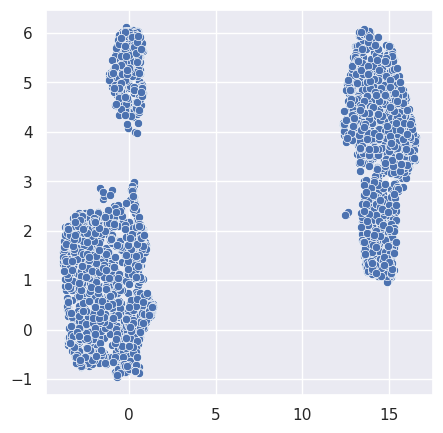

In [44]:
import seaborn as sns

sns.set(rc={"figure.figsize":(5, 5)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1])

<AxesSubplot:>

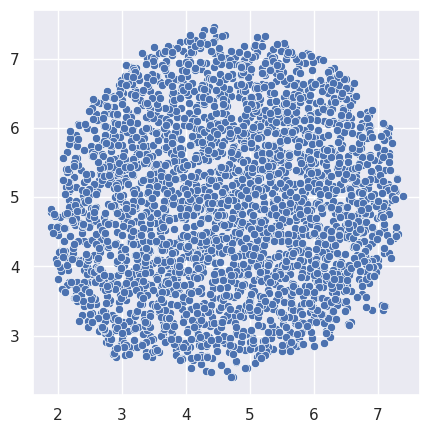

In [42]:
sns.set(rc={"figure.figsize":(5, 5)})
sns.scatterplot(x=reduced_embedding2[:, 0], y=reduced_embedding2[:, 1])

In [39]:
embeddings.shape

(2947, 64, 4, 4)

In [18]:
raw_images[:,:,90,10].mean()

0.20295149

In [43]:
raw_images2[:,:,90,10].mean()

0.20274538156813235

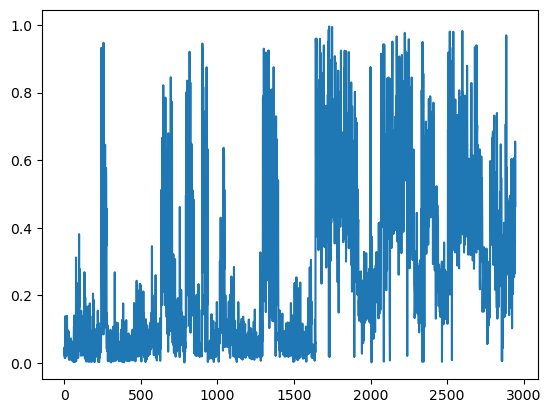

In [34]:
plt.plot(raw_images[:, 0, 50, 50])

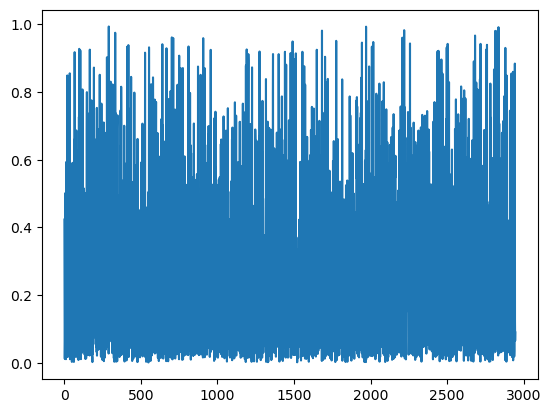

In [23]:
plt.plot(raw_images2[:, 0, 50, 50])

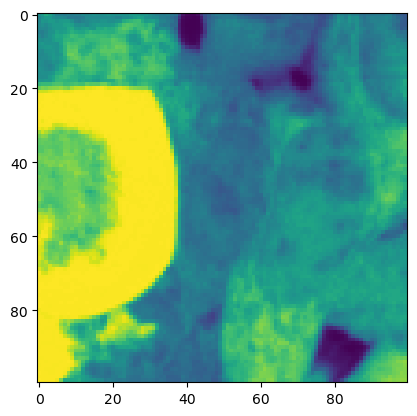

In [41]:
plt.imshow(raw_images[1912, 0])

In [26]:
raw_images3 = np.asarray(images[:2947])

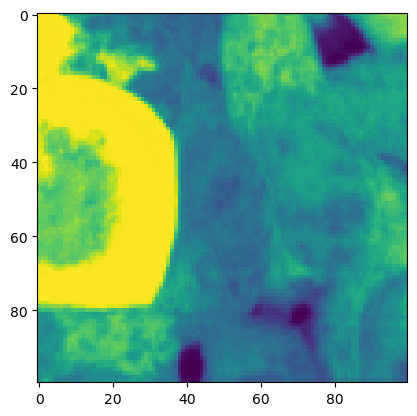

In [40]:
plt.imshow(raw_images3[1912, :, :, 0])

In [27]:
raw_images3.shape

(2947, 100, 100, 4)

In [28]:
import torch
from tqdm import tqdm


# trainer.model.to('cuda')
embeddings = []
localizations = []
for batch in tqdm(pdm2.test_loader):
    emb = trainer.model(batch['image'].to('cuda').float(), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
    localizations.append(batch['label'])
embeddings = np.concatenate(embeddings, axis=0)
localizations = np.concatenate(localizations, axis=0)

100%|██████████| 93/93 [00:03<00:00, 28.06it/s]


In [22]:
import torch
from tqdm import tqdm


# trainer.model.to('cuda')
embeddings = []
localizations = []
for batch in tqdm(torch.utils.data.DataLoader(pdm.val_images_dataset, batch_size=32, shuffle=False)):
    emb = trainer.model(batch['image'].to('cuda').float(), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
    localizations.append(batch['localization'])
embeddings = np.concatenate(embeddings, axis=0)
localizations = np.concatenate(localizations, axis=0)

100%|██████████| 2870/2870 [02:28<00:00, 19.35it/s]


In [ ]:
import torch
from tqdm import tqdm


# trainer.model.to('cuda')
embeddings = []
localizations = []
for batch in tqdm(torch.utils.data.DataLoader(pdm.val_images_dataset, batch_size=32, shuffle=True)):
    emb = trainer.model(batch['image'].to('cuda').float(), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
    localizations.append(batch['localization'])
embeddings = np.concatenate(embeddings, axis=0)
localizations = np.concatenate(localizations, axis=0)

In [7]:
import torch

batch = next(iter(torch.utils.data.DataLoader(pdm.val_images_dataset, batch_size=32, shuffle=True)))

In [33]:
trainer.model.eval()

CytoselfFull(
  (encoders): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              

In [34]:
trainer.model.training

False

In [40]:
emb_x = []
for b in batch['image']:
    emb = trainer.model(b.unsqueeze_(0).to('cuda').float(), 'vqvec2')
    emb_x.append(emb.detach().cpu().numpy())
emb_x = np.concatenate(emb_x, axis=0)

emb_y = trainer.model(batch['image'].to('cuda').float(), 'vqvec2').detach().cpu().numpy()
emb_z = trainer.model(batch['image'].to('cuda').float(), 'vqvec2').detach().cpu().numpy()

In [37]:
emb_x.shape

(32, 64, 25, 25)

In [42]:
(emb_y - emb_x).max()

7.6293945e-06

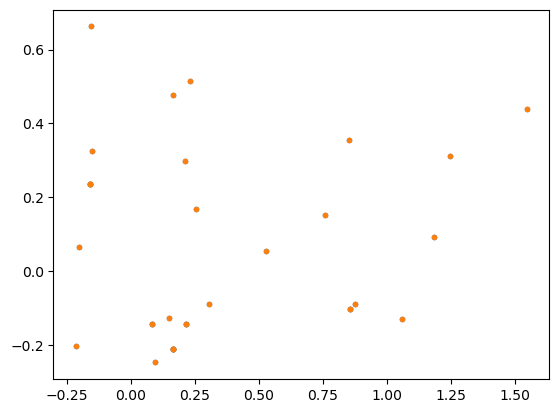

In [43]:
plt.plot(emb_y[:, 0, 0, 0], emb_y[:, 1, 0, 0], '.')
plt.plot(emb_x[:, 0, 0, 0], emb_x[:, 1, 0, 0], '.')

In [69]:
trainer.model.training

True

In [67]:
trainer.model.train()

CytoselfFull(
  (encoders): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              

In [97]:
clm.model.train()

CytoselfFull(
  (encoders): ModuleList(
    (0): EfficientNet(
      (features): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              

In [98]:
import torch
from tqdm import tqdm


clm.model.to('cuda')
embeddings = []
localizations = []
for batch in tqdm(torch.utils.data.DataLoader(pdm.val_images_dataset, batch_size=32, shuffle=True)):
    emb = clm.model(batch['image'].to('cuda').float(), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
    localizations.append(batch['localization'])
embeddings = np.concatenate(embeddings, axis=0)
localizations = np.concatenate(localizations, axis=0)

100%|██████████| 2870/2870 [02:24<00:00, 19.86it/s]


In [99]:
# localizations = pdm.test_loader.dataset.label[:, 2]
reduced_localization = localizations

In [100]:
np.save('emb_2.npy', embeddings)
np.save('loc_2.npy', localizations)

In [101]:
localizations

array(['', 'vesicles', 'cytoplasm', ..., '', '', 'cytoplasm'],
      dtype='<U16')

In [102]:
reduced_localization[reduced_localization==''] = 'other'

In [103]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [104]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))


In [105]:
import seaborn as sns

In [106]:
np.unique(reduced_localization)

array(['ER', 'Golgi', 'cytoplasm', 'mitochondria', 'nuclear_domains',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'other',
       'vesicles'], dtype='<U16')

In [107]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

<AxesSubplot:>

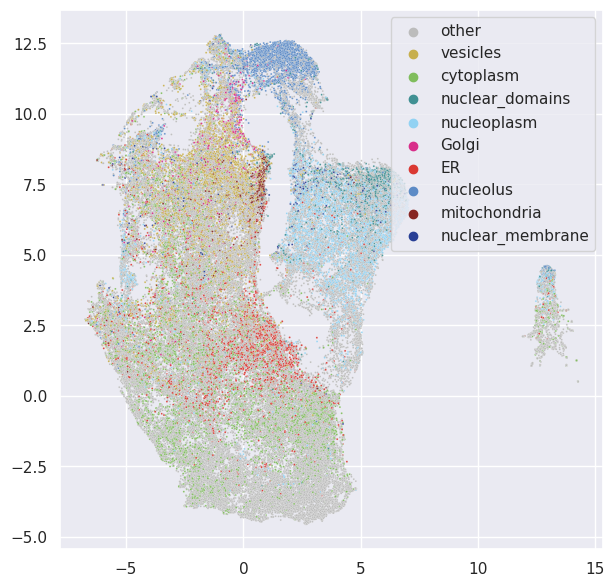

In [108]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

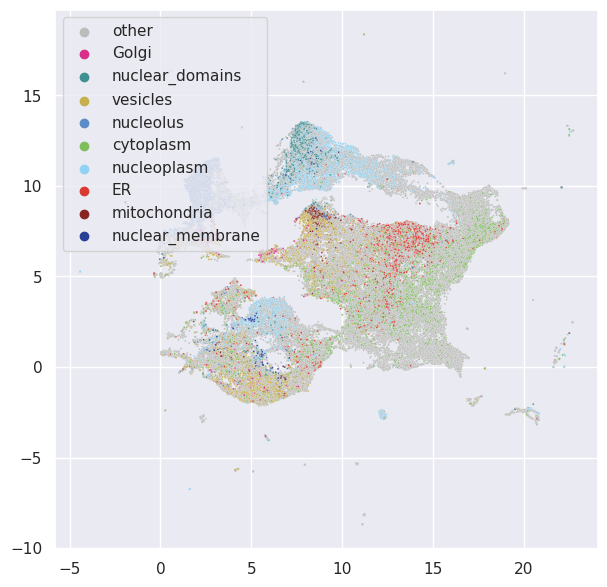

In [95]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

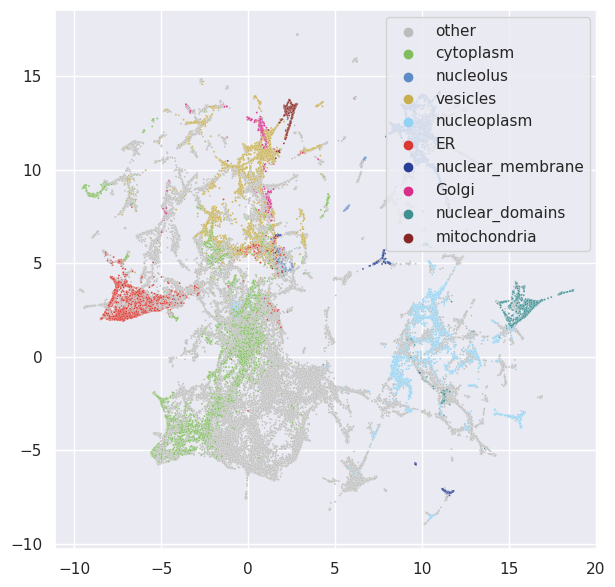

In [80]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

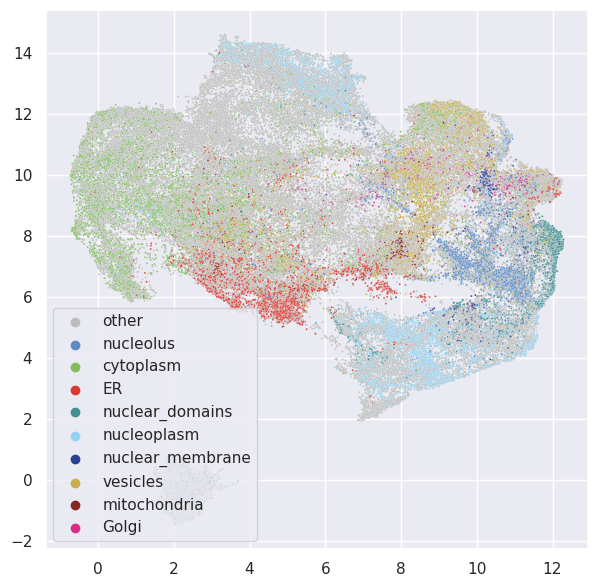

In [66]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

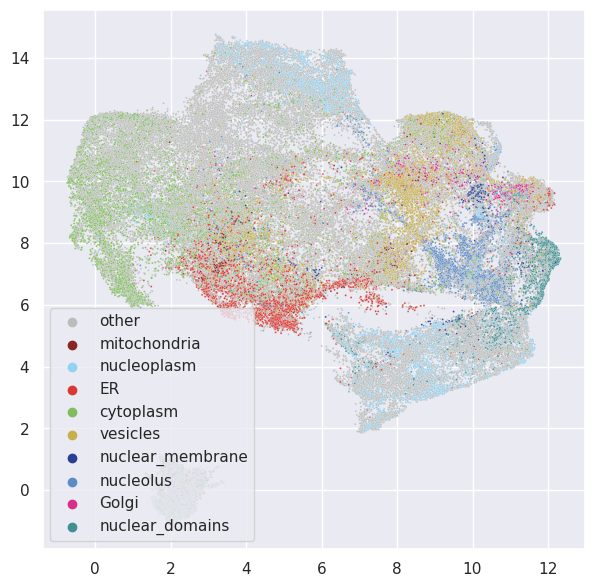

In [53]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

<AxesSubplot:>

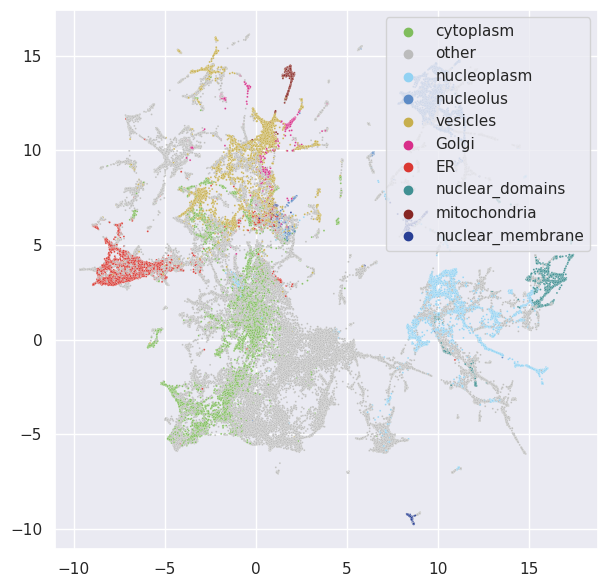

In [34]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

In [ ]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=reduced_localization, s=2, alpha=0.9, palette=label_colors)

In [ ]:
sns.set(rc={"figure.figsize":(7, 7)})
sns.scatterplot(x=reduced_embedding[keep, 0], y=reduced_embedding[keep, 1], hue=labels[keep], s=2, alpha=0.9, palette=label_colors)

In [ ]:
trainer.model

In [ ]:
import torch

torch.tensor(11)

In [ ]:
pdm

In [ ]:
from cytoself.trainer.autoencoder.cytoselffull import CytoselfFull

In [ ]:
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': 100,
    'fc_input_type': 'vqvec',
}

model = CytoselfFull(**model_args)

In [ ]:
from cytoself.trainer.autoencoder.cytoselffull import duplicate_kwargs

In [ ]:
duplicate_kwargs(model_args['vq_args'], model_args['emb_shapes'])

In [ ]:
type(model_args['vq_args'])

In [ ]:
import torch.nn as nn

image_criterion = nn.MSELoss()
labels_criterion = nn.CrossEntropyLoss()

In [ ]:
images = batch['image']
labels = batch['label']
output_images, output_logits = model(images)

In [ ]:
image_variance = 1
model.mse_loss['reconstruction1_loss'] = image_criterion(output_images, images) / image_variance
model.fc_loss = {f'fc{model.fc_output_idx[0]}_loss' :labels_criterion(output_logits, labels)}
vq_loss = torch.stack([d['loss'] for d in model.vq_loss.values()]).sum()
mse_loss = torch.stack([d for d in model.mse_loss.values()]).sum()
fc_loss = torch.stack([d for d in model.fc_loss.values()]).sum()

In [ ]:
vq_coeff = 1
fc_coeff = 1

loss = mse_loss + fc_coeff * fc_loss + vq_coeff * vq_loss

In [ ]:
loss

In [ ]:
vq_loss

In [ ]:
model.vq_loss

In [ ]:
model.perplexity

In [ ]:
model.fc_output_idx

In [ ]:
model.fc_loss

In [ ]:
output = {'loss': loss.item()}
output.update({k: v.item() for k, v in model.fc_loss.items()})
output.update({k: v.item() for k, v in model.perplexity.items()})
output.update({k: model.mse_loss[k].item() for k in sorted(model.mse_loss)})
vq_loss_dict = {}
for key0, val0 in model.vq_loss.items():
    for key1, val1 in val0.items():
        vq_loss_dict[key0 + '_' + key1] = val1.item()
output.update(vq_loss_dict)

In [ ]:
output

In [ ]:
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
output = trainer.run_one_batch(batch, 0.0167)

In [ ]:
output

In [ ]:
images = batch['image']
labels = batch['label']
output_images, output_logits = clm.model(images)
loss, all_outputs = clm._calc_losses(images, labels, output_images, output_logits)   

In [ ]:
all_outputs

In [ ]:
output2


In [ ]:
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict['visualization'])

In [ ]:
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [ ]:
analysis = AnalysisOpenCell(datamanager, trainer)

In [ ]:
analysis.plot_clustermap(num_workers=4)

## Custom trainer

In [ ]:
from proteoscope.cytoselfmodule import CytoselfLightningModule

In [ ]:
clm = CytoselfLightningModule(model_args)

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
trainer = Trainer()

In [ ]:
trainer.fit(clm, pdm)

In [ ]:
import pandas as pd

label_path = '/home/ec2-user/cytoself-data/41592_2022_1541_MOESM4_ESM.csv'
df = pd.read_csv(label_path)

In [ ]:
df.drop_duplicates(subset='gene_name', keep='first', inplace=True)

In [ ]:
df.set_index('gene_name', inplace=True)

In [ ]:
labels = pd.read_csv('/home/ec2-user/cytoself-data/labels.csv', index_col=0)

In [ ]:
labels['localization'] = labels['name'].map(df['localization'])

In [ ]:
labels

In [ ]:
labels['localization'].unique()

In [ ]:
labels.to_csv('/home/ec2-user/cytoself-data/labels.csv')

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
# Compute bi-clustering heatmap
analysis.plot_clustermap(num_workers=4)

# Prepare image data
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()[:1]

# Compute index histogram
vqindhist1 = trainer.infer_embeddings(img, 'vqindhist1')

# Reorder the index histogram according to the bi-clustering heatmap
ft_spectrum = analysis.compute_feature_spectrum(vqindhist1)

# Generate a plot
import numpy as np
import matplotlib.pyplot as plt

x_max = ft_spectrum.shape[1] + 1
x_ticks = np.arange(0, x_max, 50)
fig, ax = plt.subplots(figsize=(10, 3))
ax.stairs(ft_spectrum[0], np.arange(x_max), fill=True)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Feature index')
ax.set_ylabel('Counts')
ax.set_xlim([0, x_max])
ax.set_xticks(x_ticks, analysis.feature_spectrum_indices[x_ticks])
fig.tight_layout()
fig.show()